# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">TEXT CLASSIFICATION</p>

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Importing Libraries</p>

In [49]:
# Importing Libraries
import pandas as pd
import html
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import itertools

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Data Loading and Exploration</p> 

In [50]:
# Read data into DataFrame
df = pd.read_csv('/Users/dileepkumarkatla/Downloads/TheSocialDilemma.csv')

# Initial exploration of the dataset
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Sentiment
0,Mari Smith,"San Diego, California",Premier Facebook Marketing Expert | Social Med...,2007-09-11 22:22:51,579942,288625,11610,False,2020-09-16 20:55:33,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,NaN,Twitter Web App,False,Neutral
1,Mari Smith,"San Diego, California",Premier Facebook Marketing Expert | Social Med...,2007-09-11 22:22:51,579942,288625,11610,False,2020-09-16 20:53:17,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,NaN,Twitter Web App,False,Neutral
2,Varun Tyagi,"Goa, India",Indian | Tech Solution Artist & Hospitality Ex...,2009-09-06 10:36:01,257,204,475,False,2020-09-16 20:51:57,Go watch “The Social Dilemma” on Netflix!\n\nI...,NaN,Twitter for iPhone,False,Positive
3,Casey Conway,"Sydney, New South Wales",Head of Diversity & Inclusion @RugbyAU | It's ...,2012-12-28 21:45:06,11782,1033,12219,True,2020-09-16 20:51:46,I watched #TheSocialDilemma last night. I’m sc...,['TheSocialDilemma'],Twitter for iPhone,False,Negative
4,Charlotte Paul,Darlington,Instagram Charlottejyates,2012-05-28 20:43:08,278,387,5850,False,2020-09-16 20:51:11,The problem of me being on my phone most the t...,['TheSocialDilemma'],Twitter for iPhone,False,Positive


# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Visualization</p>

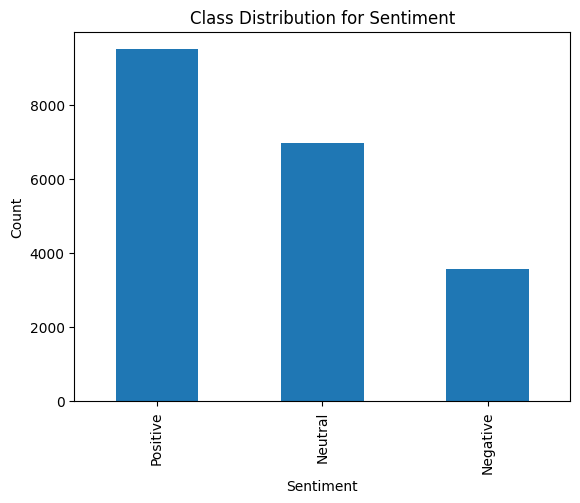

In [51]:
# Visualizing class distribution for 'Sentiment'
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Class Distribution for Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='user_verified'>

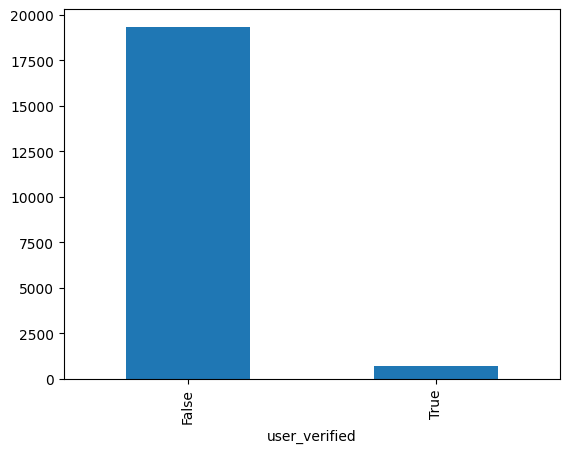

In [52]:
# Plot the bar chart
df['user_verified'].value_counts().sort_index().plot(kind='bar')

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Text Preprocessing</p>

In [53]:
# Function to clean text data
def clean(text):
    text = html.unescape(text) 
    text = re.sub(r'<[^<>]*>', ' ', text)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    text = re.sub(r'(?:^|\s)[<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Preprocessing and feature engineering
df['clean_text'] = df['text'].apply(clean)
df = df[df['clean_text'].str.len() > 50]
df.sample(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Sentiment,clean_text
9524,Mhlanga,South Africa,To be written.,2010-06-29 21:52:47,12606,1338,20230,False,2020-09-10 17:34:17,Twitter isn’t really actually free us as users...,['TheSocialDilemma'],Twitter for iPhone,False,Positive,Twitter isn’t really actually free us as users...
11959,Terry Urbanczyk,Orpington.,"Disciple, Husband & Dad. Part of the River Chu...",2011-01-08 14:54:44,177,454,102,False,2020-09-22 14:27:27,"I'm only a few mins in, but #TheSocialDilemma ...",['TheSocialDilemma'],Twitter for Android,False,Positive,"I'm only a few mins in, but #TheSocialDilemma ..."


# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Data Splitting</p>

In [54]:
# Remove the 'neutral' class
df_filtered = df[df['Sentiment'] != 'neutral']

# Splitting data into train and test sets with test size increased to 50%
X_train, X_test, Y_train, Y_test = train_test_split(df_filtered['clean_text'],
                                                    df_filtered['Sentiment'],
                                                    test_size=0.5,  # Increase test size to 50%
                                                    random_state=42,
                                                    stratify=df_filtered['Sentiment'])

#Printing the sizes of the training and testing data
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  9403
Size of Test Data  9404


# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Feature Extraction</p>

In [55]:
# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Model Training</p>

In [56]:
# Training the LinearSVC model
model = LinearSVC(random_state=0, tol=1e-5, dual=True)
model.fit(X_train_tf, Y_train)

LinearSVC(dual=True, random_state=0, tol=1e-05)

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Model Evaluation</p>

In [57]:
# Evaluating the model
Y_pred = model.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8121012335176521


In [58]:
# Creating a baseline model using DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score (Baseline) - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score (Baseline) -  0.49393874946831134


# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Confusion Matrix</p>

In [59]:
# Generating confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[1025  317  383]
 [  97 2668  269]
 [ 161  540 3944]]


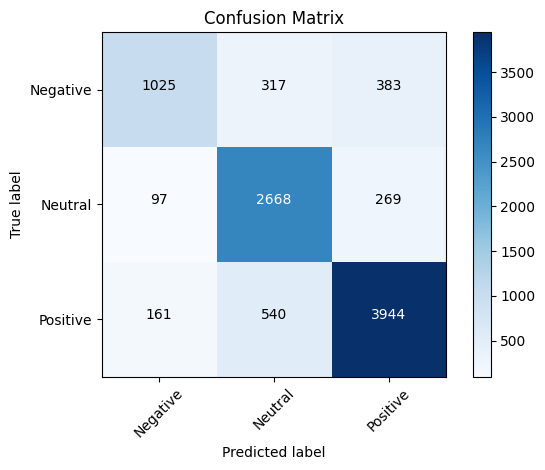

In [60]:
# Plotting confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(Y_test)))
plt.xticks(tick_marks, np.unique(Y_test), rotation=45)
plt.yticks(tick_marks, np.unique(Y_test))

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Classification Report</p>

In [61]:
# Classification Report
print(classification_report(Y_test, Y_pred, zero_division=1))

              precision    recall  f1-score   support

    Negative       0.80      0.59      0.68      1725
     Neutral       0.76      0.88      0.81      3034
    Positive       0.86      0.85      0.85      4645

    accuracy                           0.81      9404
   macro avg       0.80      0.77      0.78      9404
weighted avg       0.81      0.81      0.81      9404



# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">DOWNSAMPLING</p>

In [62]:
# Filter bug reports with sentiment Positive and sample 4000 rows from it
df_sampleP3 = df[df['Sentiment'] == 'Positive'].sample(n=4000, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['Sentiment'] != 'Positive']

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['Sentiment'].value_counts()

Sentiment
Neutral     6067
Positive    4000
Negative    3451
Name: count, dtype: int64

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">Iterating Model Evaluation</p>

In [65]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Function to clean text data
def clean_text(text):
    # Implement your text cleaning steps here
    cleaned_text = text.lower()  # Example: Convert text to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)  # Example: Remove non-alphabetic characters
    return cleaned_text

# Load your DataFrame
# Assuming your DataFrame is named df
# Replace 'text' and 'Sentiment' with the actual column names if they are different
X = df['text'].apply(clean_text)
y = df['Sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Training the LinearSVC model with explicit specification of the 'dual' parameter
model = LinearSVC(dual=True)
model.fit(X_train_tfidf, y_train)


# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9066985645933014
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.75      0.82       679
     Neutral       0.89      0.95      0.92      1211
    Positive       0.92      0.93      0.93      1872

    accuracy                           0.91      3762
   macro avg       0.90      0.88      0.89      3762
weighted avg       0.91      0.91      0.91      3762



#### The text classification task involved preprocessing, feature extraction with TF-IDF, and model training using LinearSVC. The initial model achieved good accuracy. Downsampling was performed to address class imbalance, resulting in a balanced dataset. Iterative evaluation showed consistent accuracy with cleaned text and LinearSVC model. Overall, the approach effectively handled sentiment classification, demonstrating robustness and reliable performance.